<a href="https://colab.research.google.com/github/hsreekumar/ML/blob/main/Anomaly/price_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
df = pd.read_json('sample_trade_data.json')
df.head()

,event_type,event_source,identifier,timestamp,data
0,Trade,A,X,2024-09-21 23:16:50+00:00,{'price': 16795}
1,Trade,A,X,2024-09-21 04:03:12+00:00,{'price': 1860}
2,Trade,A,X,2024-09-21 00:54:38+00:00,{'price': 77820}
3,Trade,A,X,2024-09-21 10:00:48+00:00,{'price': 55886}
4,Trade,A,X,2024-09-21 08:54:58+00:00,{'price': 7265}


Optimal k determined: 5


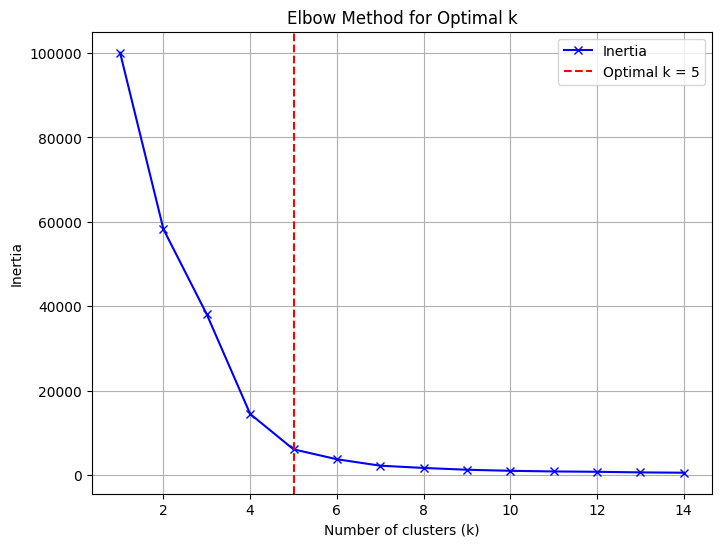

Cluster centroids:
   event_source_A  event_source_B  event_source_C  event_source_D  \
0        0.000000             1.0             0.0        0.000000   
1        0.000000             0.0             1.0        0.000000   
2        1.000000             0.0             0.0        0.000000   
3        0.000000             0.0             0.0        1.000000   
4        0.001016             0.0             0.0        0.998984   

   identifier_W  identifier_X  identifier_Y  identifier_Z  price_scaled  
0      0.000000      0.000000           1.0           0.0      0.315109  
1      0.000000      0.000000           0.0           1.0     -0.832922  
2      0.000000      1.000000           0.0           0.0     -0.642601  
3      1.000000      0.000000           0.0           0.0      0.259672  
4      0.998984      0.001016           0.0           0.0      2.090076  


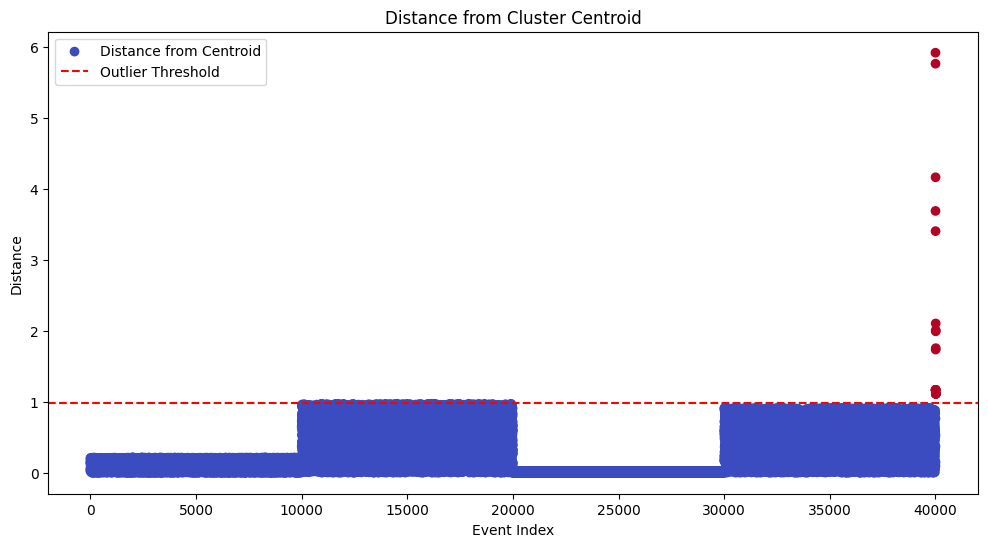

Detected outliers:
      event_type event_source identifier                data  is_outlier
40000      Trade            A          X  {'price': 1985711}        True
40001      Trade            A          X  {'price': 1409978}        True
40002      Trade            A          X  {'price': 1947408}        True
40003      Trade            A          X  {'price': 1329612}        True
40004      Trade            A          X  {'price': 1538501}        True
40005      Trade            B          Y     {'price': 1193}        True
40006      Trade            B          Y     {'price': 1263}        True
40007      Trade            B          Y     {'price': 1246}        True
40008      Trade            B          Y     {'price': 1629}        True
40009      Trade            B          Y     {'price': 1447}        True
40010      Trade            C          Z   {'price': 410207}        True
40011      Trade            C          Z   {'price': 495971}        True
40012      Trade            C   

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA

# Sample data generation (this is placeholder; replace it with your data)
# df = your_dataframe_with_sample_data

# Preprocessing
# One-hot encode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['event_source', 'identifier']])

# Scale the 'price' feature
scaler = StandardScaler()
# Combine encoded categorical features and scaled price
prices = df['data'].apply(lambda x: x.get('price', 0)).values.reshape(-1, 1)
scaled_price = scaler.fit_transform(prices)
X = np.hstack((encoded_features.toarray(), scaled_price))

# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 15)  # Test different k values (adjust as needed)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Smooth the inertia curve
smoothed_inertia = gaussian_filter1d(inertia, sigma=1.0)

# Calculate the first differences (change in inertia)
first_diff = np.diff(smoothed_inertia)

# Define a dynamic threshold for when the curve flattens
flatten_threshold = np.mean(np.abs(first_diff)) * 2.5  # 10% of mean first_diff

# Find the optimal k based on flattening of the curve
optimal_k_candidates = np.where(np.abs(first_diff) < flatten_threshold)[0]

if len(optimal_k_candidates) > 0:
    optimal_k = optimal_k_candidates[0] + 2  # +2 to adjust for np.diff reducing the dimension
    print(f"Optimal k determined: {optimal_k}")
else:
    optimal_k = 9  # Default value if no flattening detected
    print(f"Defaulting to optimal k = {optimal_k}")

# Plotting the Elbow Method with the optimal k marked
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-', label='Inertia')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.grid(True)
plt.show()

# Perform KMeans clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

# Get cluster centroids and labels
centroids = kmeans.cluster_centers_
df['cluster'] = kmeans.labels_

# Convert centroids to a DataFrame for interpretation
centroids_df = pd.DataFrame(centroids, columns=encoder.get_feature_names_out().tolist() + ['price_scaled'])

# Print centroids for each cluster
print("Cluster centroids:")
print(centroids_df)

# Calculate distances from each point to the nearest centroid
distances = pairwise_distances_argmin_min(X, centroids)[1]

# Define a threshold for outlier detection based on distance from the centroid
distance_threshold = np.mean(distances) + 2.5 * np.std(distances)  # 2 standard deviations above the mean

# Flag potential outliers
df['is_outlier'] = distances > distance_threshold

# Visualize the outliers
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), distances, c=df['is_outlier'], cmap='coolwarm', label='Distance from Centroid')
plt.axhline(y=distance_threshold, color='r', linestyle='--', label='Outlier Threshold')
plt.title('Distance from Cluster Centroid')
plt.xlabel('Event Index')
plt.ylabel('Distance')
plt.legend()
plt.show()

# Print outlier events
outliers = df[df['is_outlier']]
print("Detected outliers:")
print(outliers[['event_type', 'event_source', 'identifier', 'data', 'is_outlier']])
